<a href="https://colab.research.google.com/github/Cheryleen5/Go_Fish_RL/blob/main/RL_IA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Streaming output truncated to the last 5000 lines.
Player 5 cannot go fish, deck is empty
Player 1 didn't get 10
Player 1 cannot go fish, deck is empty
Player 2 didn't get 9
Player 2 cannot go fish, deck is empty
Player 3 didn't get 3
Player 3 cannot go fish, deck is empty
Player 4 didn't get 2
Player 4 cannot go fish, deck is empty
Player 5 didn't get J
Player 5 cannot go fish, deck is empty
Player 1 got 10 from Player 5
Player 1 collects 4 10s
Game Over!
Player 1 score: 1
Player 2 score: 0
Player 3 score: 0
Player 4 score: 0
Player 5 score: 0
Player 1 didn't get Q
Player 1 goes fish and draws 5
Player 2 got 4 from Player 1
Player 3 got 7 from Player 5
Player 4 didn't get 10
Player 4 goes fish and draws 9
Player 5 didn't get 10
Player 5 goes fish and draws K
Player 1 didn't get Q
Player 1 goes fish and draws J
Player 2 got 2 from Player 4
Player 3 got 8 from Player 1
Player 4 didn't get 10
Player 4 goes fish and draws 10
Player 5 didn't get 10
Player 5 goes fish and draws 5
Player 1 d

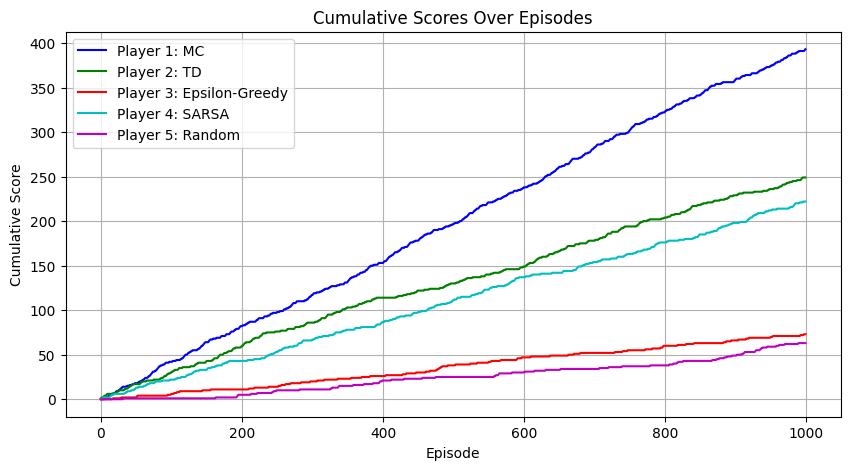

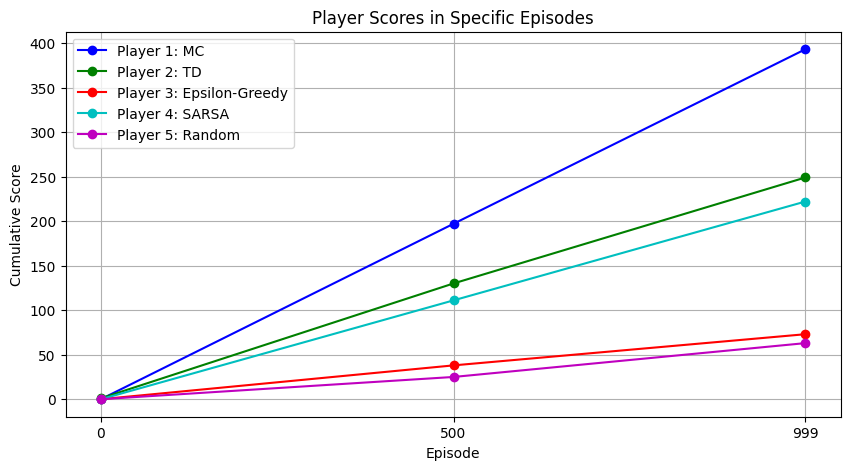

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

class GoFishGame:
    def __init__(self, players):
        self.players = players
        for player in self.players:
            if isinstance(player, RLPlayer):
                player.set_players(self.players)
        self.initialize_deck()

    def initialize_deck(self):
        self.deck = [str(i) for i in range(2, 11)] * 4 + ['J', 'Q', 'K', 'A'] * 4
        random.shuffle(self.deck)

    def deal_cards(self):
        if len(self.deck) < 7 * len(self.players):
            print("Not enough cards in the deck to deal!")
            return False

        for player in self.players:
            player.hand = [self.deck.pop() for _ in range(7)]
            player.score = 0  # Initialize score for each player
        return True

    def play(self):
        while True:
            if not self.deal_cards():
                print("Game cannot start due to insufficient cards!")
                return

            turn = 0
            while True:
                current_player = self.players[turn % len(self.players)]
                current_player.play_turn(self.players, self.deck)

                if any(player.score >= 1 for player in self.players):  # A player wins if they have 2 sets of four
                    break

                turn += 1

            self.end_game()
            break

    def end_game(self):
        print("Game Over!")
        for player in self.players:
            print(f"Player {player.id} score: {player.score}")

class Player:
    def __init__(self, player_id, name):
        self.id = player_id
        self.name = name
        self.hand = []
        self.score = 0

    def play_turn(self, players, deck):
        if isinstance(self, RLPlayer):
            action = self.select_action()
            requested_player = action['requested_player']
            requested_card = action['requested_card']
            self.request_card(requested_player, requested_card, deck)
        else:
            requested_player = random.choice([p for p in players if p != self])
            requested_card = random.choice(self.hand) if self.hand else None

            if requested_card:
                print(f"Player {self.id} requests {requested_card} from Player {requested_player.id}")
                self.request_card(requested_player, requested_card, deck)
            else:
                print(f"Player {self.id} has no cards to request.")

    def request_card(self, other_player, card, deck):
        if card in other_player.hand:
            print(f"Player {self.id} got {card} from Player {other_player.id}")
            other_player.hand.remove(card)
            self.hand.append(card)
            self.find_match(card)
        else:
            print(f"Player {self.id} didn't get {card}, going fish...")
            self.go_fish(deck)

        self.update_score(card)

    def update_score(self, card):
        if self.hand.count(card) == 4:
            print(f"Player {self.id} collects 4 {card}s")
            self.score += 1
            self.hand = [c for c in self.hand if c != card]

    def go_fish(self, deck):
        if deck:
            drawn_card = deck.pop()
            self.hand.append(drawn_card)
            print(f"Player {self.id} goes fish and draws {drawn_card}")
            self.find_match(drawn_card)
        else:
            print(f"Player {self.id} cannot go fish, deck is empty")

    def find_match(self, card):
        if self.hand.count(card) == 4:
            print(f"Player {self.id} collects 4 {card}s")
            self.score += 1
            self.hand = [c for c in self.hand if c != card]

class RLPlayer(Player):
    def __init__(self, player_id, name, method='MC', epsilon=0.1):
        super().__init__(player_id, name)
        self.epsilon = epsilon
        self.q_values = defaultdict(float)
        self.alpha = 0.1
        self.gamma = 0.9
        self.method = method
        self.players = []
        self.last_state = None
        self.last_action = None
        self.last_reward = None

    def set_players(self, players):
        self.players = players

    def select_action(self):
        if random.random() < self.epsilon:
            requested_player = random.choice([p for p in self.players if p != self])
            requested_card = random.choice(self.hand)
            return {'requested_player': requested_player, 'requested_card': requested_card}
        else:
            best_value = -float('inf')
            best_action = None
            state = tuple(sorted(self.hand))
            for card in self.hand:
                for player in self.players:
                    if player != self:
                        action_value = self.q_values.get((state, (player.id, card)), 0)
                        if action_value > best_value:
                            best_value = action_value
                            best_action = {'requested_player': player, 'requested_card': card}

            if best_action is None:
                requested_player = random.choice([p for p in self.players if p != self])
                requested_card = random.choice(self.hand)
                best_action = {'requested_player': requested_player, 'requested_card': requested_card}

        return best_action

    def request_card(self, other_player, card, deck):
        self.last_state = tuple(sorted(self.hand))
        self.last_action = (other_player.id, card)

        if card in other_player.hand:
            print(f"Player {self.id} got {card} from Player {other_player.id}")
            other_player.hand.remove(card)
            self.hand.append(card)
            self.find_match(card)
            self.last_reward = 1
        else:
            print(f"Player {self.id} didn't get {card}")
            self.go_fish(deck)
            self.last_reward = -1

        if self.method == 'MC':
            self.learn_monte_carlo(self.last_reward, self.last_state, self.last_action)
        elif self.method == 'TD':
            self.learn_td(self.last_reward, self.last_state, self.last_action)
        elif self.method == 'SARSA':
            self.learn_sarsa(self.last_reward)

        self.update_epsilon()

    def go_fish(self, deck):
        if deck:
            drawn_card = deck.pop()
            self.hand.append(drawn_card)
            print(f"Player {self.id} goes fish and draws {drawn_card}")
            self.find_match(drawn_card)
        else:
            print(f"Player {self.id} cannot go fish, deck is empty")

    def find_match(self, card):
        if self.hand.count(card) == 4:
            print(f"Player {self.id} collects 4 {card}s")
            self.score += 1
            self.hand = [c for c in self.hand if c != card]

    def learn_monte_carlo(self, reward, state, action):
        self.q_values[(state, action)] += self.alpha * (reward - self.q_values[(state, action)])

    def learn_td(self, reward, state, action):
        current_value = self.q_values.get((state, action), 0)
        next_max = self.get_max_value(state)
        self.q_values[(state, action)] = current_value + self.alpha * (reward + self.gamma * next_max - current_value)

    def learn_sarsa(self, reward):
        current_value = self.q_values.get((self.last_state, self.last_action), 0)
        next_action_value = self.get_max_value(self.last_state)
        self.q_values[(self.last_state, self.last_action)] += self.alpha * (reward + self.gamma * next_action_value - current_value)

    def get_max_value(self, state):
        return max(self.q_values.get((state, (player.id, card)), 0) for player in self.players for card in self.hand)

    def update_epsilon(self):
        self.epsilon = max(0.01, self.epsilon * 0.99)

def plot_cumulative_scores(cumulative_scores, num_episodes):
    plt.figure(figsize=(10, 5))
    colors = ['b', 'g', 'r', 'c', 'm']  # Define colors for each player
    method_labels = ['MC', 'TD', 'Epsilon-Greedy', 'SARSA', 'Random']  # Method labels

    for i, (player_id, scores) in enumerate(cumulative_scores.items()):
        plt.plot(scores, label=f'Player {player_id}: {method_labels[i]}', color=colors[i])

    plt.xlabel('Episode')
    plt.ylabel('Cumulative Score')
    plt.title('Cumulative Scores Over Episodes')
    plt.legend()
    plt.grid()
    plt.show()

def plot_player_scores_in_specific_episodes(cumulative_scores, episode_indices):
    plt.figure(figsize=(10, 5))
    colors = ['b', 'g', 'r', 'c', 'm']  # Define colors for each player
    method_labels = ['MC', 'TD', 'Epsilon-Greedy', 'SARSA', 'Random']  # Method labels

    for i, player_id in enumerate(cumulative_scores.keys()):
        scores = [cumulative_scores[player_id][i] for i in episode_indices]
        plt.plot(episode_indices, scores, marker='o', label=f'Player {player_id}: {method_labels[i]}', color=colors[i])

    plt.xticks(episode_indices, episode_indices)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Score')
    plt.title('Player Scores in Specific Episodes')
    plt.legend()
    plt.grid()
    plt.show()

def run_multiple_episodes(num_episodes):
    rl_rewards = []
    cumulative_scores = defaultdict(list)
    value_over_time = defaultdict(list)
    epsilon_over_time = defaultdict(list)

    for episode in range(num_episodes):
      players = [
          RLPlayer(1, 'Player 1', method='MC'),
          RLPlayer(2, 'Player 2', method='TD'),
          RLPlayer(3, 'Player 3', method='Epsilon'),  # Epsilon-Greedy
          RLPlayer(4, 'Player 4', method='SARSA'),
          RLPlayer(5, 'Player 5', method='Random')
      ]
      game = GoFishGame(players)
      game.play()


      # Update cumulative scores
      for player in players:
          if cumulative_scores[player.id]:
              cumulative_scores[player.id].append(cumulative_scores[player.id][-1] + player.score)
          else:
              cumulative_scores[player.id].append(player.score)

          # Collect Q-values and epsilon values for RLPlayers
          if isinstance(player, RLPlayer):
              state = tuple(sorted(player.hand))
              max_value = player.get_max_value(state)
              value_over_time[player.id].append(max_value)
              epsilon_over_time[player.id].append(player.epsilon)

    return rl_rewards, value_over_time, epsilon_over_time, cumulative_scores


# Example usage
if __name__ == "__main__":
    num_episodes = 1000 # Adjust this for more or fewer episodes
    rl_rewards, value_over_time, epsilon_over_time, cumulative_scores = run_multiple_episodes(num_episodes)

    # Plot cumulative scores over episodes
    plot_cumulative_scores(cumulative_scores, num_episodes)

    # Define episode indices for the first, middle, and last episodes
    episodes = list(range(num_episodes))
    episode_indices = [0, num_episodes // 2, num_episodes - 1]  # First, Middle, Last

    # Plot player scores in specific episodes
    plot_player_scores_in_specific_episodes(cumulative_scores, episode_indices)
